Found 160 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


2022-07-06 13:49:04.989402: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-11.4/lib64
2022-07-06 13:49:04.989436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-07-06 13:49:04.990933: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate comp

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

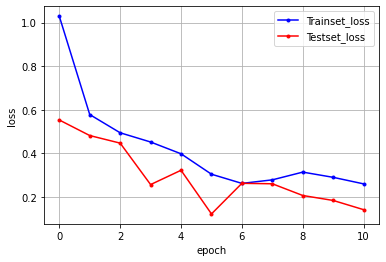

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, optimizers
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

np.random.seed(3)
tf.random.set_seed(3)



# ImageDataGenerator() : 데이터의 수 늘리는 함수
train_datagen = ImageDataGenerator(rescale=1./255,         # 주어진 이미지의 크기 변경, 원본영상이 0~255 RGB값을 가지고 있으므로, 255로 나눌경우 0~1 값으로 변환되어 학습 속도 상승, 정규화 과정
                                   horizontal_flip=True,   # 수평 대칭 이미지를 50% 확률로 만들어 추가
                                   width_shift_range=0.1,  # 전체 크기의 10% 범위에서 좌우 이동
                                   height_shift_range=0.1, # 전체 크기의 10% 범위에서 위아래 이동
                                   fill_mode='nearest')    # 이미지를 축소/회전하거나 이동시 생기는 빈공간 어떻게 채울지 결정, nearest옵션 선택시 가장 비슷한 색으로 채움

# flow_from_directory() : 폴더에 저장된 데이터 호출
train_generator = train_datagen.flow_from_directory(
       '../data/22_AugmentationData/train/', 
       target_size=(150, 150),  # 이미지 크기 설정
       batch_size=5,
       class_mode='binary')     # 치매/정상 이진 분류이므로 바이너리 모드로 실행


# 데이터 부불리기는 학습셋에만 적용
# 테스트셋은 실제 정보를 그대로 유지하는 편이 과적합 위험 감소, 정규화만 진행
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
       '../data/22_AugmentationData/test/',
       target_size=(150, 150),  # 이미지 크기 설정
       batch_size=5,
       class_mode='binary')     # 치매/정상 이진 분류이므로 바이너리 모드로 실행


### 모델 VG16 사용
# 미리 학습된 모델로 학습 구종에 따라 VGG16, VGG19등의 모델 이름이 주어져 있음
transfer_model = VGG16(weights='imagenet',  # 이미지넷으로 트레이닝
                       include_top=False,   # 마지막 층, 즉 분류 담당하는 곳 불러올지 정하는 옵션으로 로컬 네트워크에 연결할 것이므로 False
                       input_shape=(150, 150, 3))

transfer_model.trainable = False # 불러올 부분은 새롭게 학습되는 것이 아니므로 학습되지 않도록 False
transfer_model.summary()


# 내 모델 설정
finetune_model = models.Sequential()
finetune_model.add(transfer_model) # VGG16 Model 그대로 호출
finetune_model.add(Flatten())
finetune_model.add(Dense(64))
finetune_model.add(Activation('relu'))
finetune_model.add(Dropout(0.5))
finetune_model.add(Dense(1)) # 최종 분류를 위한 새로운 학습
finetune_model.add(Activation('sigmoid'))
finetune_model.summary()


# 모델 실행 옵션 설정
finetune_model.compile(loss='binary_crossentropy',
                       optimizer=optimizers.Adam(0.002),
                       metrics=['accuracy'])

# 학습 조기 중단 설정
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)      

# 모델 실행
history = finetune_model.fit(train_generator,
                             epochs=20,
                             validation_data=test_generator,
                             validation_steps=10,
                             callbacks=[early_stopping_callback])

# 학습셋과 검증셋 오차
y_loss = history.history['loss']
y_vloss = history.history['val_loss']

# 그래프
x_len = np.arange(len(y_vloss))
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()